# Supervised Learning Models for Customer Classification

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

In [6]:
cleaned_data = pd.read_csv("data/02_removed_outliers_redundant.csv", index_col=0)
clustered_data = pd.read_csv("results/clustering/clustered_data_results.csv", index_col=0)

In [19]:
clustered_data.head()



,Education,Marital_Status,Income,Recency,Response,Age,Customer_Since,Total_Spent,RatioWines,RatioFruits,RatioMeatProducts,RatioFishProducts,RatioSweetProducts,RatioGoldProds,Total_Accepted_Campaign,Total_Purchase,Total_Web_Engagement,Cluster
0,-0.938689,-1.351057,0.323276,0.309449,2.391652,1.020547,1.528805,1.717324,-0.294804,0.084229,0.738542,0.439362,0.067335,-0.612882,-0.437212,1.526686,1.618563,0
1,-0.938689,-1.351057,-0.252104,-0.382368,-0.418121,1.278260,-1.187852,-0.964299,-0.230315,-0.226666,-0.210163,0.026779,-0.232271,0.953516,-0.437212,-1.139954,-0.986405,1
2,-0.938689,0.740161,0.980665,-0.797458,-0.418121,0.333312,-0.204916,0.298931,0.390517,0.240217,-0.691438,0.907844,-0.404182,-0.615664,-0.437212,0.544240,0.750240,0
3,-0.938689,0.740161,-1.213087,-0.797458,-0.418121,-1.298871,-1.059428,-0.920448,-1.106821,0.460671,1.064771,1.490876,0.104939,-0.240253,-0.437212,-0.859255,-0.407523,1
4,1.065316,0.740161,0.330838,1.554719,-0.418121,-1.041158,-0.950762,-0.298109,-0.219153,0.933219,0.261548,0.473023,0.232078,-0.789094,-0.437212,0.544240,0.171359,0


In [ ]:
# Prepare features and set cluster as target
X_all = clustered_data.drop('Cluster', axis=1)
y = clustered_data['Cluster']

In [8]:
# define feature sets as mentioned in the project proposal
# all features (for existing customers with purchase history)
all_features = X_all.columns.tolist()

In [9]:
# Remove purchase-related and spending-related features
purchase_related = ['Total_Spent', 'RatioWines', 'RatioFruits', 'RatioMeatProducts', 
                   'RatioFishProducts', 'RatioSweetProducts', 'RatioGoldProds', 
                   'Total_Accepted_Campaign', 'Total_Purchase', 'Total_Web_Engagement']

In [10]:
# seperate between demo and othe type of featruess
demographic_features = [f for f in all_features if f not in purchase_related]

print("Feature sets:")
print(f"All features ({len(all_features)}): {all_features}")
print(f"Demographic features ({len(demographic_features)}): {demographic_features}")

Feature sets:
All features (17): ['Education', 'Marital_Status', 'Income', 'Recency', 'Response', 'Age', 'Customer_Since', 'Total_Spent', 'RatioWines', 'RatioFruits', 'RatioMeatProducts', 'RatioFishProducts', 'RatioSweetProducts', 'RatioGoldProds', 'Total_Accepted_Campaign', 'Total_Purchase', 'Total_Web_Engagement']
Demographic features (7): ['Education', 'Marital_Status', 'Income', 'Recency', 'Response', 'Age', 'Customer_Since']


In [29]:
# Define models to test
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'SVM': SVC(random_state=42, probability=True),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Neural Network': MLPClassifier(random_state=42, max_iter=1000)
}

In [ ]:
# evaluate all 6 models 
def evaluate_models(X, y, feature_set_name):
    print(f"Evaluating Models with {feature_set_name}")
    
    # split the data 80: 20
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                        random_state=42, stratify=y)

    results = {}
    
    for name, model in models.items():
        print(f"\nTraining {name}...")
        
        # cross-validation 5 fold
        cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
        
        # fit and predict
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        
        # Calculate metrics
        test_accuracy = model.score(X_test, y_test)
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        
        results[name] = {
            'model': model,
            # 'scaler': scaler,
            'cv_mean': cv_scores.mean(),
            'cv_std': cv_scores.std(),
            'test_accuracy': test_accuracy,
            'roc_auc': roc_auc,
            'y_test': y_test,
            'y_pred': y_pred,
            'y_pred_proba': y_pred_proba,
            'classification_report': classification_report(y_test, y_pred)
        }
        
        print(f"  CV Accuracy: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")
        print(f"  Test Accuracy: {test_accuracy:.3f}")
        print(f"  ROC AUC: {roc_auc:.3f}")
    
    return results, X_train, X_test, y_train, y_test

In [22]:
# Evaluate models with all features
results_all = evaluate_models(X_all, y, "All Features")[0]

# Evaluate models with demographic features only
X_demo = X_all[demographic_features]
results_demo = evaluate_models(X_demo, y, "Demographic Features Only")[0]

Evaluating Models with All Features

Training Logistic Regression...
  CV Accuracy: 0.993 (+/- 0.008)
  Test Accuracy: 0.998
  ROC AUC: 1.000

Training Random Forest...
  CV Accuracy: 0.963 (+/- 0.015)
  Test Accuracy: 0.954
  ROC AUC: 0.995

Training Gradient Boosting...
  CV Accuracy: 0.967 (+/- 0.013)
  Test Accuracy: 0.961
  ROC AUC: 0.994

Training SVM...
  CV Accuracy: 0.979 (+/- 0.010)
  Test Accuracy: 0.975
  ROC AUC: 0.999

Training K-Nearest Neighbors...
  CV Accuracy: 0.948 (+/- 0.022)
  Test Accuracy: 0.934
  ROC AUC: 0.983

Training Neural Network...
  CV Accuracy: 0.994 (+/- 0.008)
  Test Accuracy: 0.991
  ROC AUC: 1.000
Evaluating Models with Demographic Features Only

Training Logistic Regression...
  CV Accuracy: 0.841 (+/- 0.047)
  Test Accuracy: 0.828
  ROC AUC: 0.891

Training Random Forest...
  CV Accuracy: 0.857 (+/- 0.015)
  Test Accuracy: 0.856
  ROC AUC: 0.905

Training Gradient Boosting...
  CV Accuracy: 0.853 (+/- 0.037)
  Test Accuracy: 0.826
  ROC AUC: 0.89

In [23]:
# compare all models
comparison_data = []

for feature_set, results in [("All Features", results_all), ("Demographic Only", results_demo)]:
    for model_name, result in results.items():
        comparison_data.append({
            'Feature Set': feature_set,
            'Model': model_name,
            'CV Accuracy': result['cv_mean'],
            'Test Accuracy': result['test_accuracy'],
            'ROC AUC': result['roc_auc']
        })

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.round(3))

         Feature Set                Model  CV Accuracy  Test Accuracy  ROC AUC
0       All Features  Logistic Regression        0.993          0.998    1.000
1       All Features        Random Forest        0.963          0.954    0.995
2       All Features    Gradient Boosting        0.967          0.961    0.994
3       All Features                  SVM        0.979          0.975    0.999
4       All Features  K-Nearest Neighbors        0.948          0.934    0.983
5       All Features       Neural Network        0.994          0.991    1.000
6   Demographic Only  Logistic Regression        0.841          0.828    0.891
7   Demographic Only        Random Forest        0.857          0.856    0.905
8   Demographic Only    Gradient Boosting        0.853          0.826    0.897
9   Demographic Only                  SVM        0.845          0.838    0.897
10  Demographic Only  K-Nearest Neighbors        0.830          0.824    0.856
11  Demographic Only       Neural Network        0.8

All features outperform demographic only.

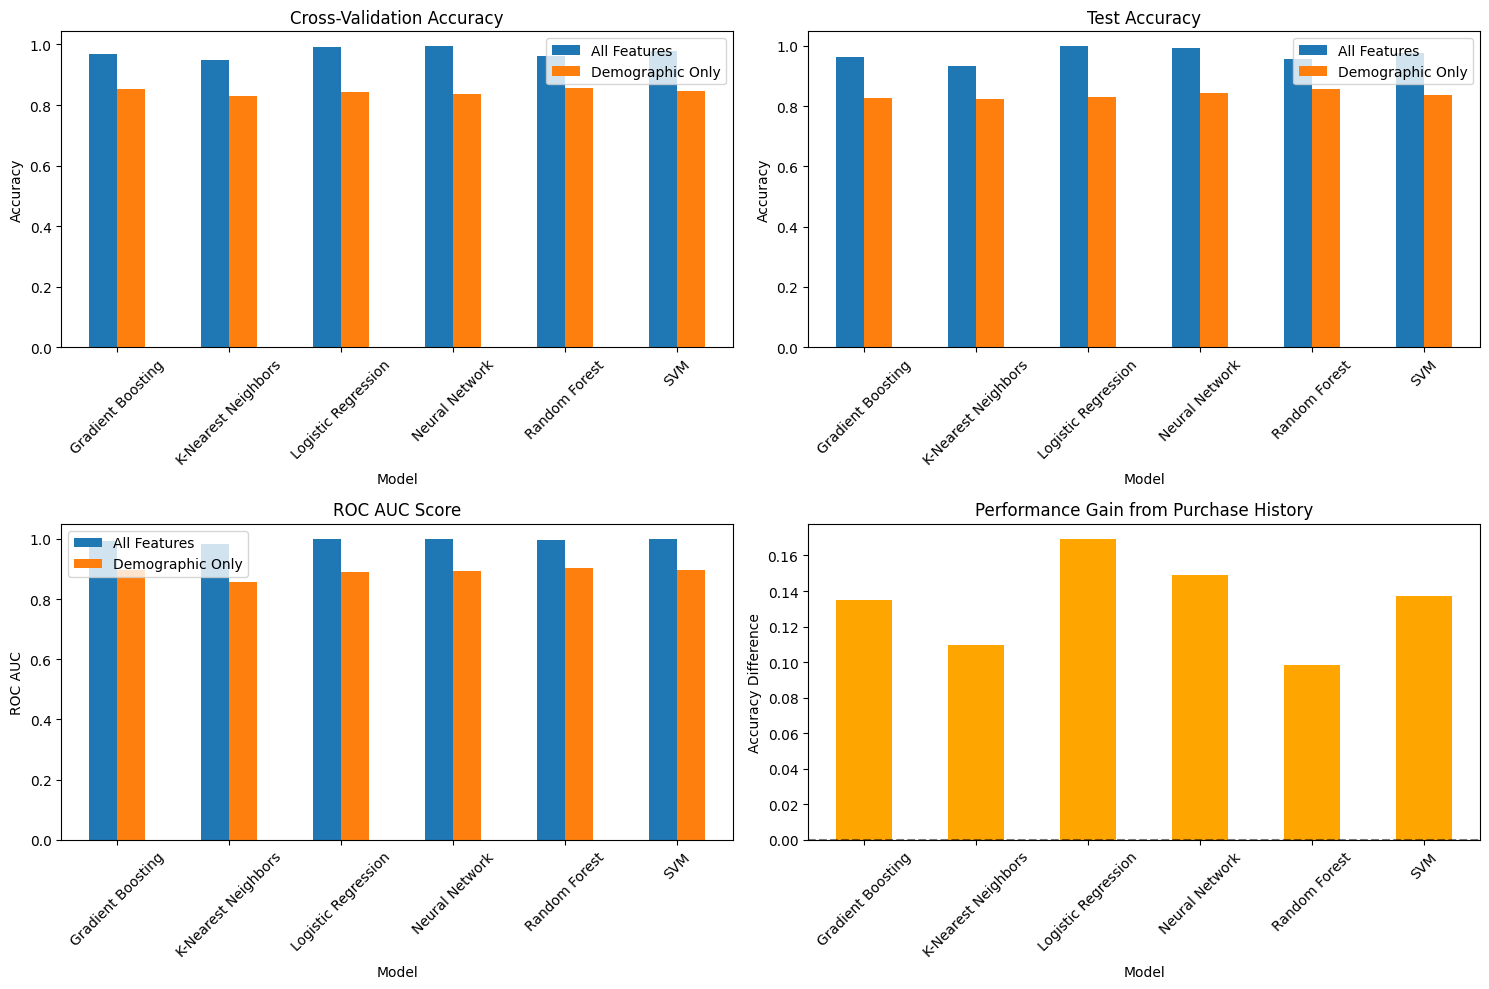

In [24]:
# Create visualization of model performance
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# CV Accuracy comparison
pivot_cv = comparison_df.pivot(index='Model', columns='Feature Set', values='CV Accuracy')
pivot_cv.plot(kind='bar', ax=axes[0, 0], rot=45)
axes[0, 0].set_title('Cross-Validation Accuracy')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend()

# Test Accuracy comparison
pivot_test = comparison_df.pivot(index='Model', columns='Feature Set', values='Test Accuracy')
pivot_test.plot(kind='bar', ax=axes[0, 1], rot=45)
axes[0, 1].set_title('Test Accuracy')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()

# ROC AUC comparison
pivot_roc = comparison_df.pivot(index='Model', columns='Feature Set', values='ROC AUC')
pivot_roc.plot(kind='bar', ax=axes[1, 0], rot=45)
axes[1, 0].set_title('ROC AUC Score')
axes[1, 0].set_ylabel('ROC AUC')
axes[1, 0].legend()

# Performance difference (All Features - Demographic Only)
performance_diff = pivot_test['All Features'] - pivot_test['Demographic Only']
performance_diff.plot(kind='bar', ax=axes[1, 1], color='orange', rot=45)
axes[1, 1].set_title('Performance Gain from Purchase History')
axes[1, 1].set_ylabel('Accuracy Difference')
axes[1, 1].axhline(y=0, color='black', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig('plots/model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

In [25]:
# Find best models for each feature set
best_all = max(results_all.items(), key=lambda x: x[1]['test_accuracy'])
best_demo = max(results_demo.items(), key=lambda x: x[1]['test_accuracy'])

print(f"\nBest model with all features: {best_all[0]} (Accuracy: {best_all[1]['test_accuracy']:.3f})")
print(f"Best model with demographic features: {best_demo[0]} (Accuracy: {best_demo[1]['test_accuracy']:.3f})")

# stat for the best models
print(f"\nBest All Features Model: {best_all[0]}")
print(best_all[1]['classification_report'])

print(f"\nBest Demographic Model: {best_demo[0]}")
print(best_demo[1]['classification_report'])



Best model with all features: Logistic Regression (Accuracy: 0.998)
Best model with demographic features: Random Forest (Accuracy: 0.856)

Best All Features Model: Logistic Regression
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       275
           1       1.00      0.99      1.00       162

    accuracy                           1.00       437
   macro avg       1.00      1.00      1.00       437
weighted avg       1.00      1.00      1.00       437


Best Demographic Model: Random Forest
              precision    recall  f1-score   support

           0       0.86      0.92      0.89       275
           1       0.85      0.75      0.79       162

    accuracy                           0.86       437
   macro avg       0.85      0.83      0.84       437
weighted avg       0.86      0.86      0.85       437



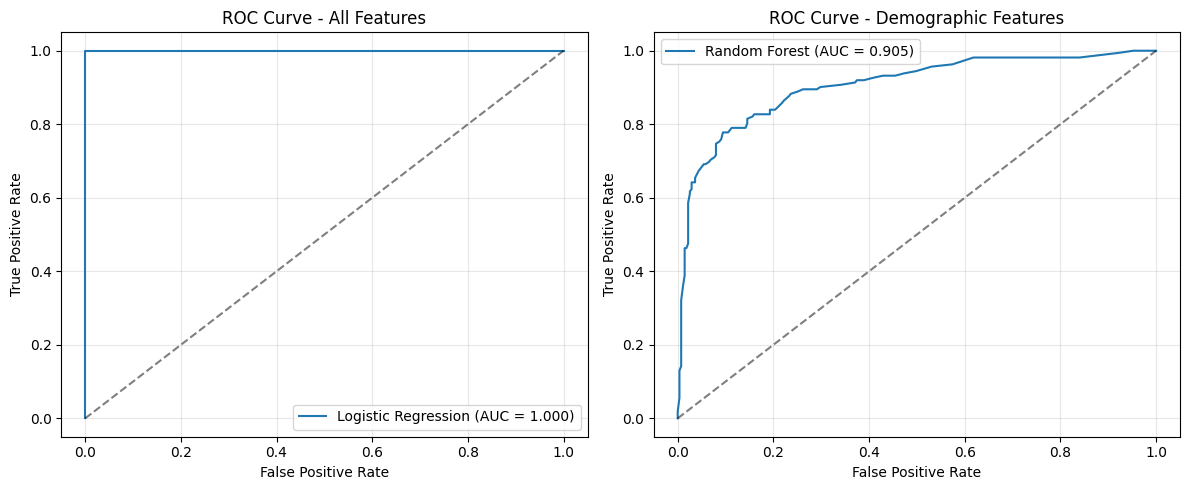

In [26]:
# ROC Curves for best models
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
fpr, tpr, _ = roc_curve(best_all[1]['y_test'], best_all[1]['y_pred_proba'])
plt.plot(fpr, tpr, label=f'{best_all[0]} (AUC = {best_all[1]["roc_auc"]:.3f})')
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - All Features')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
fpr, tpr, _ = roc_curve(best_demo[1]['y_test'], best_demo[1]['y_pred_proba'])
plt.plot(fpr, tpr, label=f'{best_demo[0]} (AUC = {best_demo[1]["roc_auc"]:.3f})')
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Demographic Features')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('plots/best_models_roc_curves.png', dpi=300, bbox_inches='tight')
plt.show()


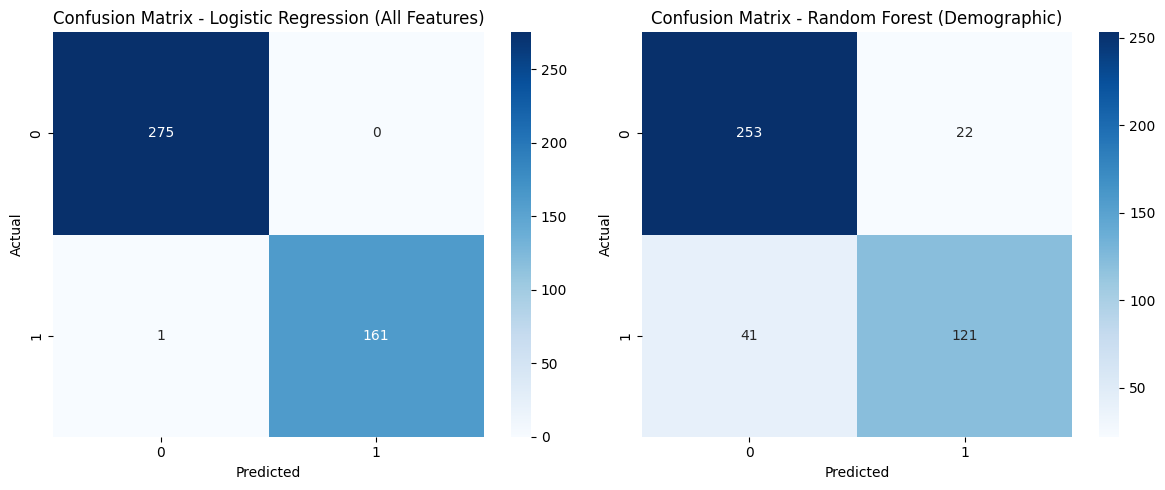

In [27]:
# confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

cm_all = confusion_matrix(best_all[1]['y_test'], best_all[1]['y_pred'])
sns.heatmap(cm_all, annot=True, fmt='d', ax=axes[0], cmap='Blues')
axes[0].set_title(f'Confusion Matrix - {best_all[0]} (All Features)')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

cm_demo = confusion_matrix(best_demo[1]['y_test'], best_demo[1]['y_pred'])
sns.heatmap(cm_demo, annot=True, fmt='d', ax=axes[1], cmap='Blues')
axes[1].set_title(f'Confusion Matrix - {best_demo[0]} (Demographic)')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.savefig('plots/best_models_confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

Both models achieved high accuracy, especially with full features (up to 99.8% with logistic regression), validating the segmentation. Models can effectively classify customers into the two segments.Purchase history significantly improves classification accuracy..  Using only demographic data still yields reasonable performance, supporting targeted marketing strategies.